In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/Microsoft_Stock.csv',
                 infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [ ]:
df.isna().sum()
df.dropna(inplace=True)

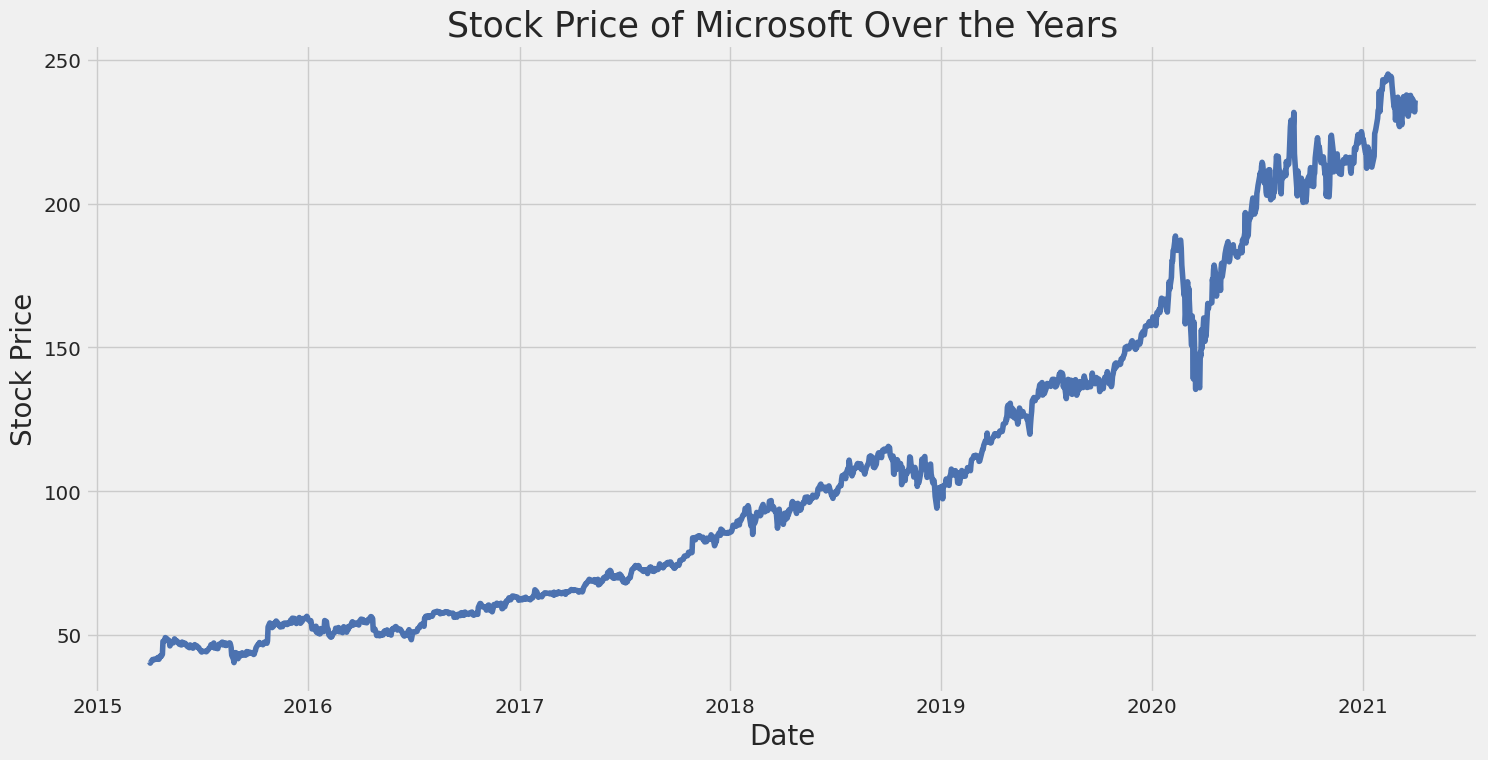

In [ ]:
plt.figure(figsize=(16,8))

plt.plot(df['Close'], label='Close Price history',color='b')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft Over the Years',size=25);

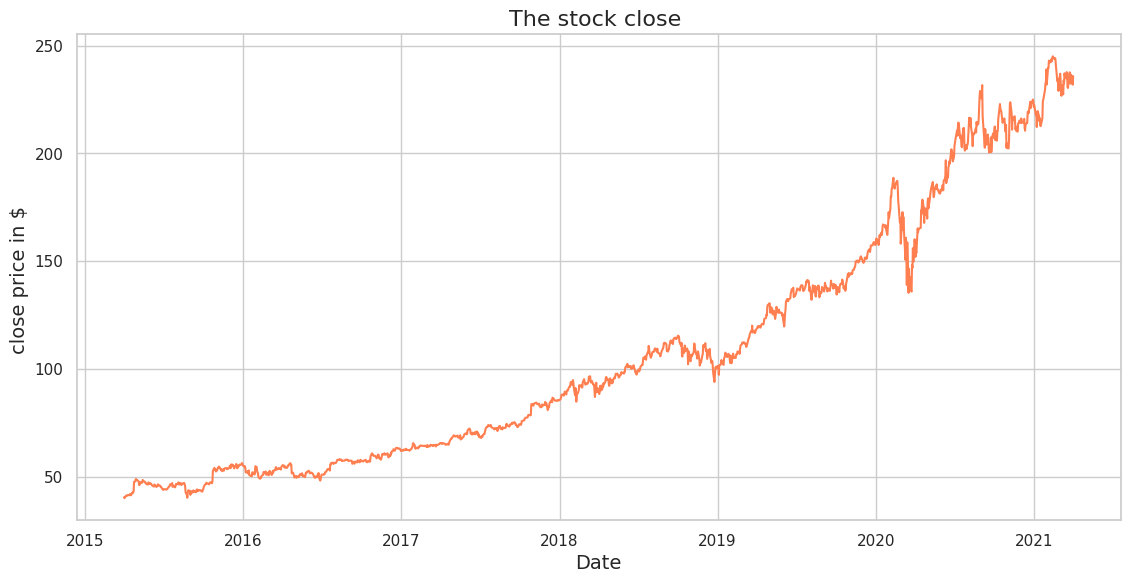

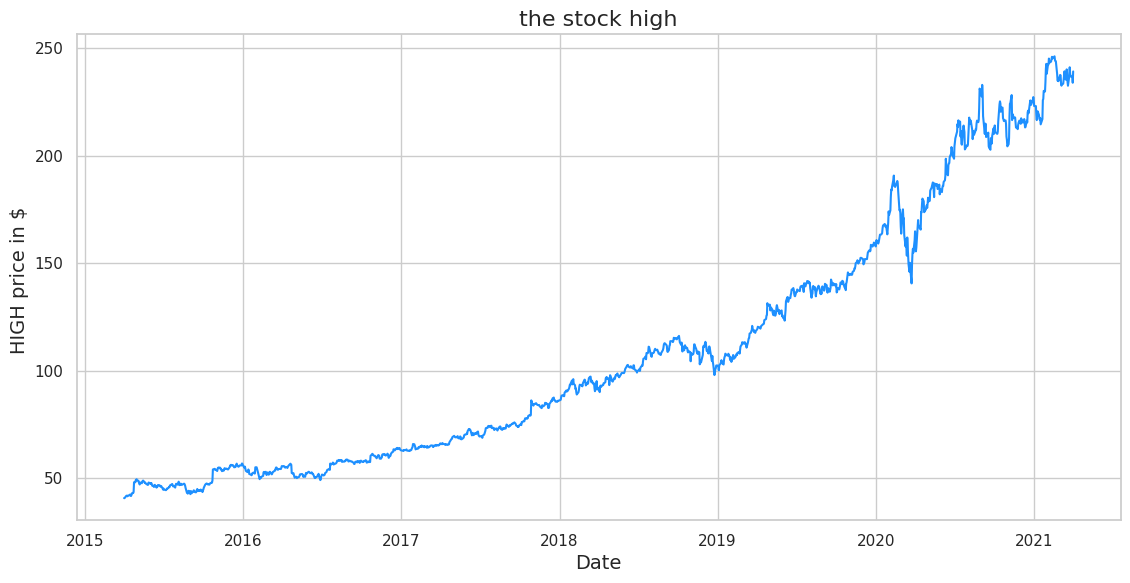

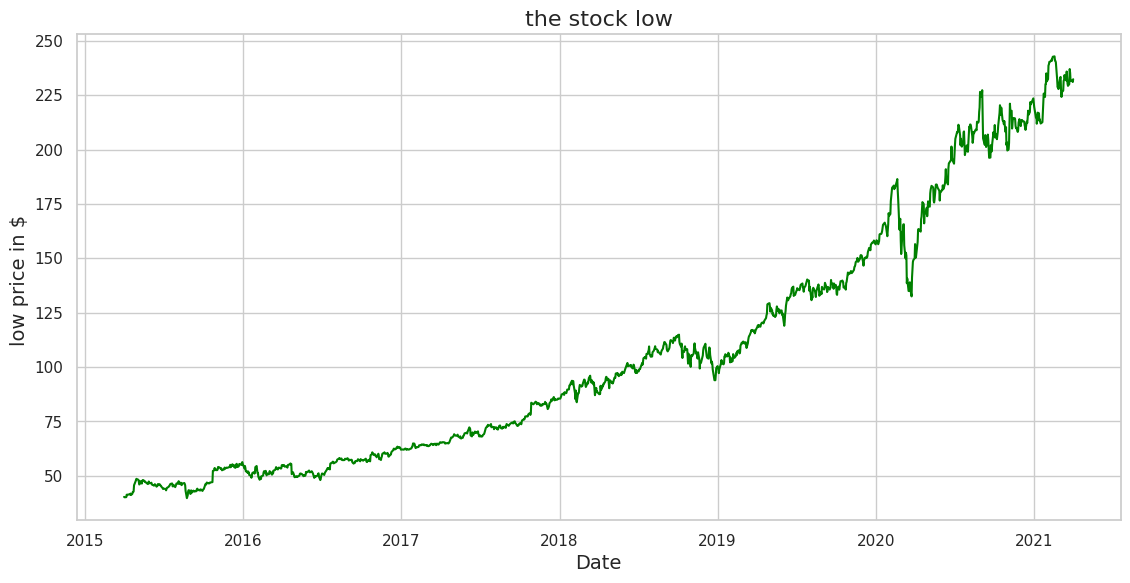

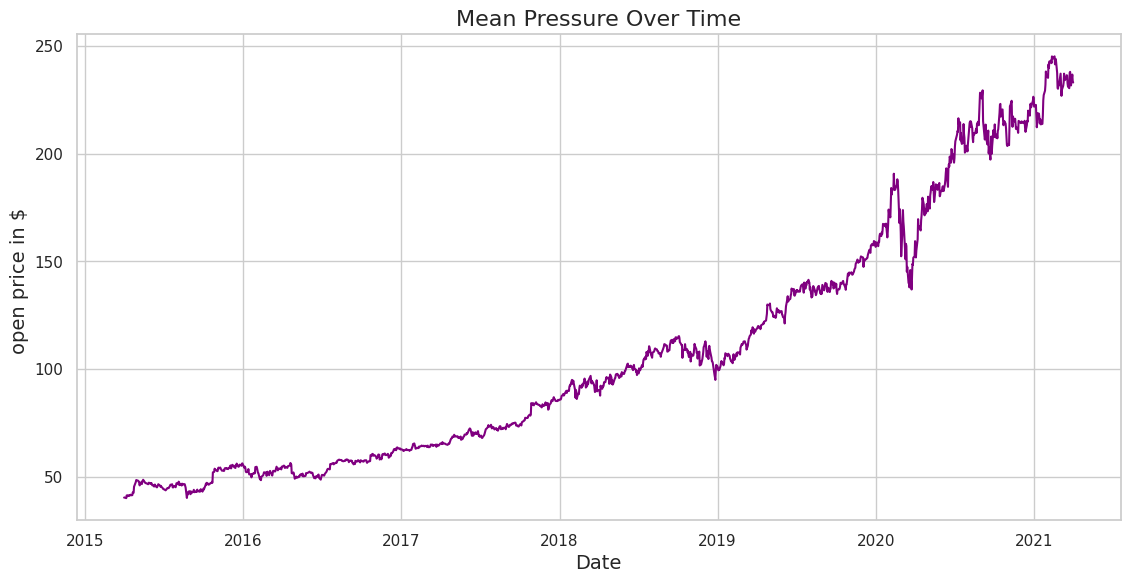

In [ ]:


sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='Close', data=df, color='coral')
plt.title('The stock close ', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('close price in $ ', fontsize=14)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='High', data=df, color='dodgerblue')
plt.title('the stock high', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('HIGH price in $ ', fontsize=14)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='Low', data=df, color='green')
plt.title('the stock low', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('low price in $ ', fontsize=14)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='Open', data=df, color='purple')
plt.title('Mean Pressure Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('open price in $ ', fontsize=14)
plt.show()

In [ ]:
len(df)

1511

In [ ]:
#train = df.iloc[:test_ind]
#test = df.iloc[test_ind:]

In [ ]:
#len(train)

In [ ]:
#len(test)
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))
print(train.shape)
print(test.shape)

1359 152
(1359, 5)
(152, 5)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
y_train_scaled = scaler.fit_transform(train[['Close']])
y_test_scaled = scaler.transform(test[['Close']])

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 24

X_train, y_train = create_dataset(train_scaled[:, np.r_[:train_scaled.shape[1]-2, -1]], y_train_scaled, time_steps)
X_test, y_test = create_dataset(test_scaled[:, np.r_[:train_scaled.shape[1]-2, -1]], y_test_scaled, time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1335, 24, 4) (1335, 1)
(128, 24, 4) (128, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
n_features = X_train.shape[2]
print(n_features)

4


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(time_steps, n_features))))
model.add(Dropout(rate=0.2))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Bidirectional(LSTM(units=32, return_sequences=False)))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.summary()

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), callbacks=early_stop)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.0442 - val_loss: 0.0408
Epoch 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0041 - val_loss: 0.0164
Epoch 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 0.0222


<Axes: >

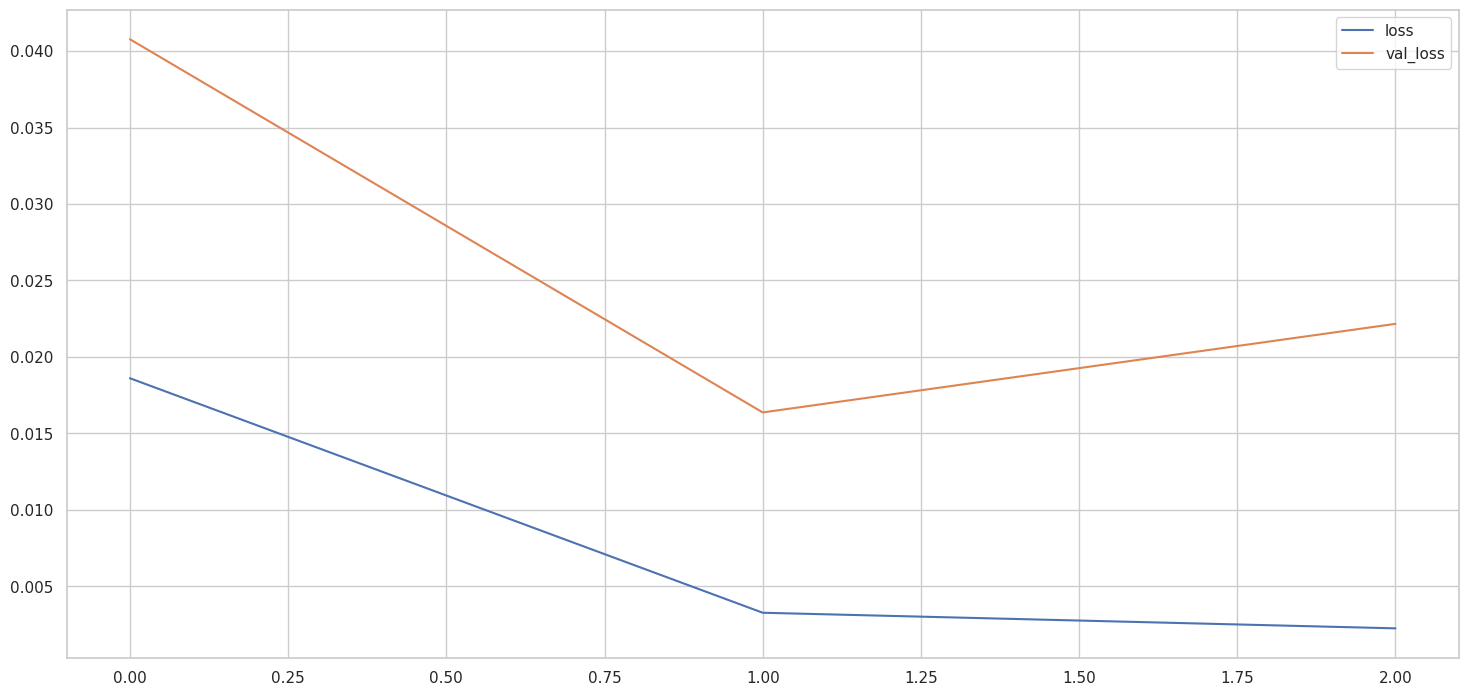

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
y_pred = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    return print("\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [ ]:
eval_metrics(y_test, y_pred)


mae: 0.12066393373000395 
mse: 0.016376169261455346 
rmse: 0.12796940752170163


In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse transform işlemi
y_test_inv = scaler.inverse_transform(y_test_reshaped)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

In [ ]:
forecast_df = pd.DataFrame(y_pred_inv, columns=['Close'], index=pd.date_range(start='2021-04-01', periods=len(y_pred_inv), freq='W'))
forecast_df['High'] = df['High'].iloc[-len(y_pred_inv):].values
forecast_df['Low'] = df['Low'].iloc[-len(y_pred_inv):].values
forecast_df['Open'] = df['Open'].iloc[-len(y_pred_inv):].values
forecast_df['Volume'] = df['Volume'].iloc[-len(y_pred_inv):].values

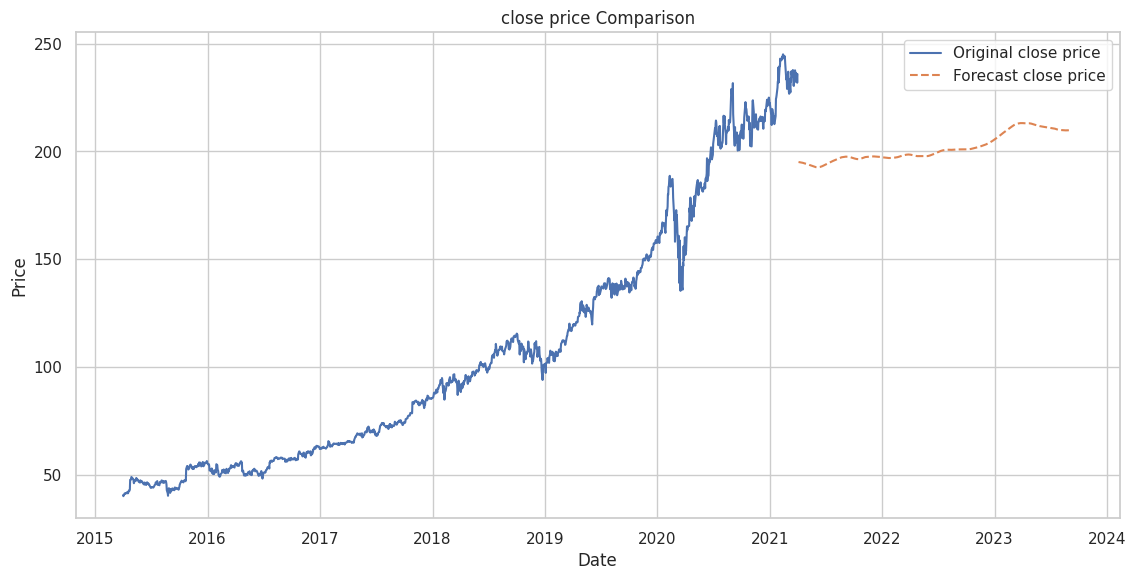

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original close price')
plt.plot(forecast_df.index, forecast_df['Close'], label='Forecast close price', linestyle='--')
plt.title('close price Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
gru_model= Sequential()
gru_model.add(Bidirectional(GRU(units=128, return_sequences=True, input_shape=(time_steps, n_features))))
gru_model.add(Dropout(rate=0.2))
gru_model.add(Bidirectional(GRU(units=64, return_sequences=True)))
gru_model.add(Bidirectional(GRU(units=32, return_sequences=False)))

gru_model.add(Dense(units=64, activation='relu'))
gru_model.add(Dropout(rate=0.2))
gru_model.add(Dense(units=32, activation='relu'))
gru_model.add(Dense(units=16, activation='relu'))
gru_model.add(Dense(units=1))

optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mse')

gru_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = gru_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0371 - val_loss: 0.0052
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - val_loss: 0.0172
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0019 - val_loss: 0.0219
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017 - val_loss: 0.0178
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0094


In [ ]:
y_pred = gru_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

In [ ]:
y_test_inv = scaler.inverse_transform(y_test_reshaped)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

In [ ]:
forecast_df = pd.DataFrame(y_pred_inv, columns=['Close'], index=pd.date_range(start='2021-04-01', periods=len(y_pred_inv), freq='W'))
forecast_df['High'] = df['High'].iloc[-len(y_pred_inv):].values
forecast_df['Low'] = df['Low'].iloc[-len(y_pred_inv):].values
forecast_df['Open'] = df['Open'].iloc[-len(y_pred_inv):].values
forecast_df['Volume'] = df['Volume'].iloc[-len(y_pred_inv):].values

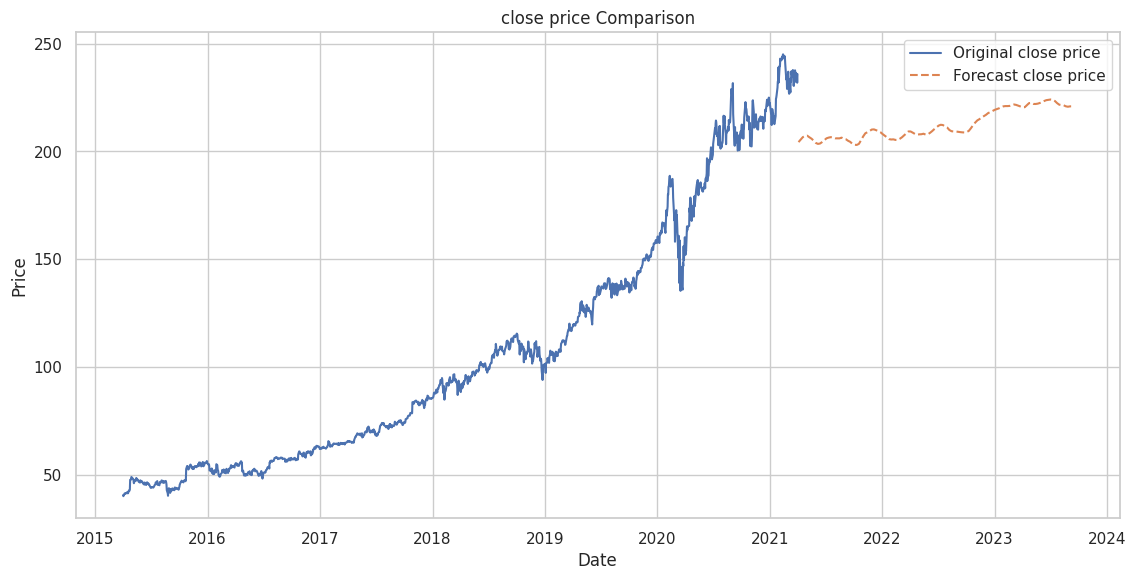

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original close price')
plt.plot(forecast_df.index, forecast_df['Close'], label='Forecast close price', linestyle='--')
plt.title('close price Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.layers import Flatten, MaxPooling1D, Conv1D
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 23, 64)              │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 50)                  │          35,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,877 (140.14 KB)

 Trainable params: 35,877 (140.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = model_cnn.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0203 - val_loss: 0.0022
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6936e-04 - val_loss: 0.0024
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1648e-04 - val_loss: 0.0040
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7735e-04 - val_loss: 0.0017
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6209e-04 - val_loss: 0.0031


In [ ]:
y_pred = model_cnn.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

In [ ]:
y_test_inv = scaler.inverse_transform(y_test_reshaped)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

In [ ]:
forecast_df = pd.DataFrame(y_pred_inv, columns=['Close'], index=pd.date_range(start='2021-04-01', periods=len(y_pred_inv), freq='W'))
forecast_df['High'] = df['High'].iloc[-len(y_pred_inv):].values
forecast_df['Low'] = df['Low'].iloc[-len(y_pred_inv):].values
forecast_df['Open'] = df['Open'].iloc[-len(y_pred_inv):].values
forecast_df['Volume'] = df['Volume'].iloc[-len(y_pred_inv):].values

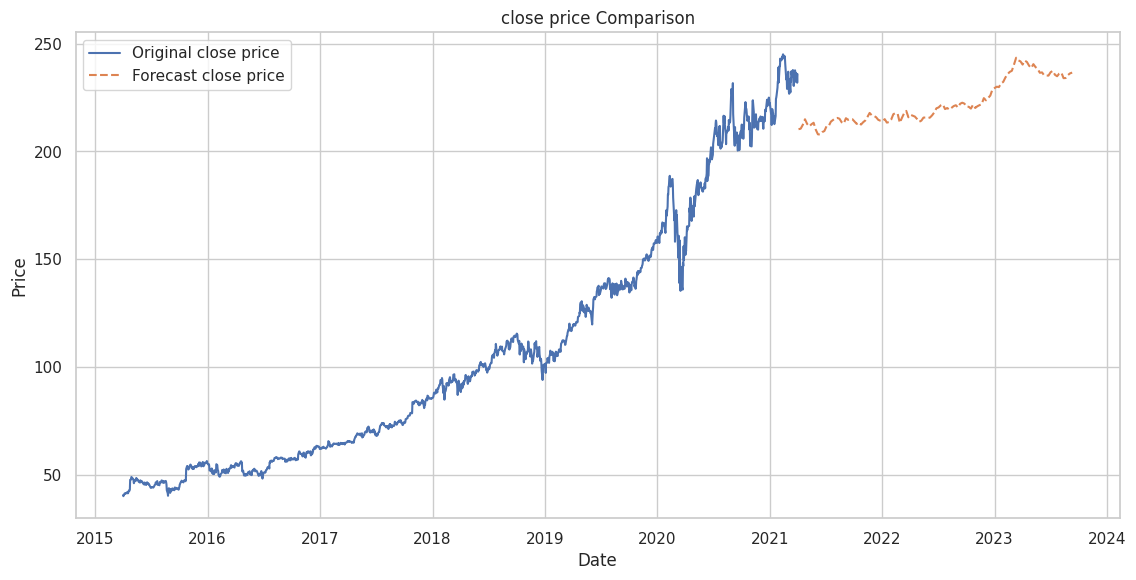

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original close price')
plt.plot(forecast_df.index, forecast_df['Close'], label='Forecast close price', linestyle='--')
plt.title('close price Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

model_trans3 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=.4,#
    dropout=0.25,#
)

model_trans3.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model_trans3.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
)

model_trans3.evaluate(X_test, y_test, verbose=1)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 721ms/step - loss: 0.1434 - val_loss: 0.2484
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0636 - val_loss: 0.2174
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0572 - val_loss: 0.1917
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0488 - val_loss: 0.1639
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0420 - val_loss: 0.1889
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5186  


0.5747023820877075

In [ ]:
y_pred = model_trans3.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

In [ ]:
y_test_inv = scaler.inverse_transform(y_test_reshaped)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

In [ ]:
forecast_df = pd.DataFrame(y_pred_inv, columns=['Close'], index=pd.date_range(start='2021-04-01', periods=len(y_pred_inv), freq='W'))
forecast_df['High'] = df['High'].iloc[-len(y_pred_inv):].values
forecast_df['Low'] = df['Low'].iloc[-len(y_pred_inv):].values
forecast_df['Open'] = df['Open'].iloc[-len(y_pred_inv):].values
forecast_df['Volume'] = df['Volume'].iloc[-len(y_pred_inv):].values

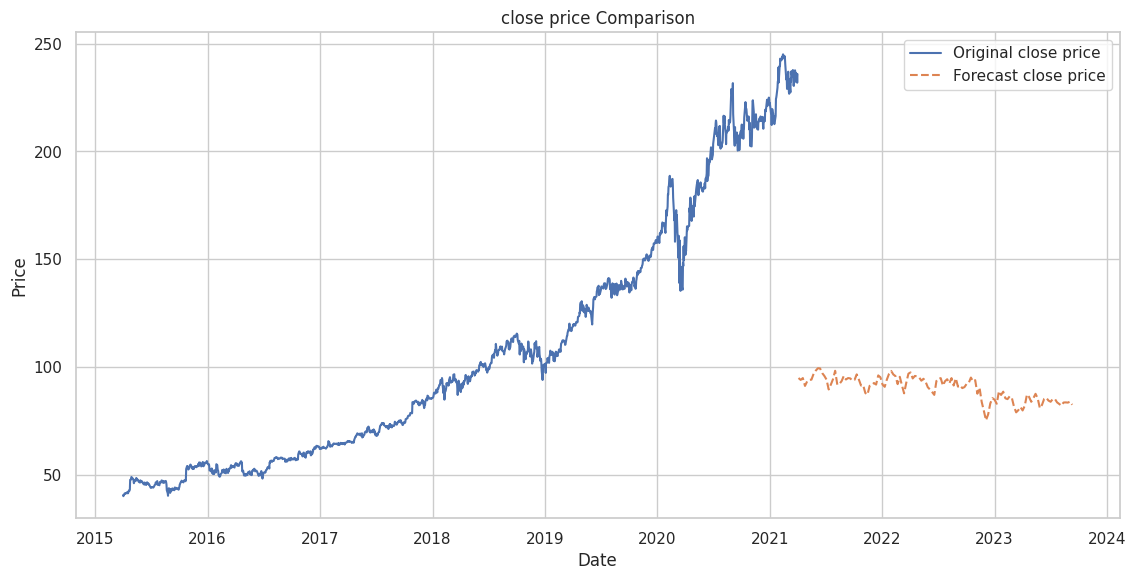

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original close price')
plt.plot(forecast_df.index, forecast_df['Close'], label='Forecast close price', linestyle='--')
plt.title('close price Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, Conv1D

In [ ]:
def get_model_cnn_lstm():
    model = Sequential()
    model.add(tf.keras.Input(shape=(None,X_train_series_sub.shape[2], X_train_series_sub.shape[3])))#shape=(X_train.shape[1], X_train.shape[2])
    model.add(TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(6, return_sequences=True, activation='relu')))
    model.add(Bidirectional(LSTM(6, return_sequences=False, activation='relu')))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
subsequences= X_train.shape[1]//time_steps
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, time_steps, 4))
X_valid_series_sub = X_test.reshape((X_test.shape[0], subsequences, time_steps, 4))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (1335, 1, 24, 4)
Validation set shape (128, 1, 24, 4)


In [ ]:
model_cnnlstm = get_model_cnn_lstm()
model_cnnlstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, None, 24, 64)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, None, 12, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, None, 768)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, None, 12)            │          37,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 12)                  │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,445 (150.18 KB)

 Trainable params: 38,445 (150.18 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_cnn_history2= model_cnnlstm.fit(X_train_series_sub, y_train, epochs=5, batch_size=32, validation_data=(X_valid_series_sub, y_test),
                 shuffle=True)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.1163 - val_loss: 0.0024
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7852e-04 - val_loss: 0.0028
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2651e-04 - val_loss: 0.0017
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2720e-04 - val_loss: 0.0017


In [ ]:
y_pred = model_cnnlstm.predict(X_valid_series_sub)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

In [ ]:
y_test_inv = scaler.inverse_transform(y_test_reshaped)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

In [ ]:
y_test_inv = scaler.inverse_transform(y_test_reshaped)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

In [ ]:
forecast_df = pd.DataFrame(y_pred_inv, columns=['Close'], index=pd.date_range(start='2021-04-01', periods=len(y_pred_inv), freq='W'))
forecast_df['High'] = df['High'].iloc[-len(y_pred_inv):].values
forecast_df['Low'] = df['Low'].iloc[-len(y_pred_inv):].values
forecast_df['Open'] = df['Open'].iloc[-len(y_pred_inv):].values
forecast_df['Volume'] = df['Volume'].iloc[-len(y_pred_inv):].values

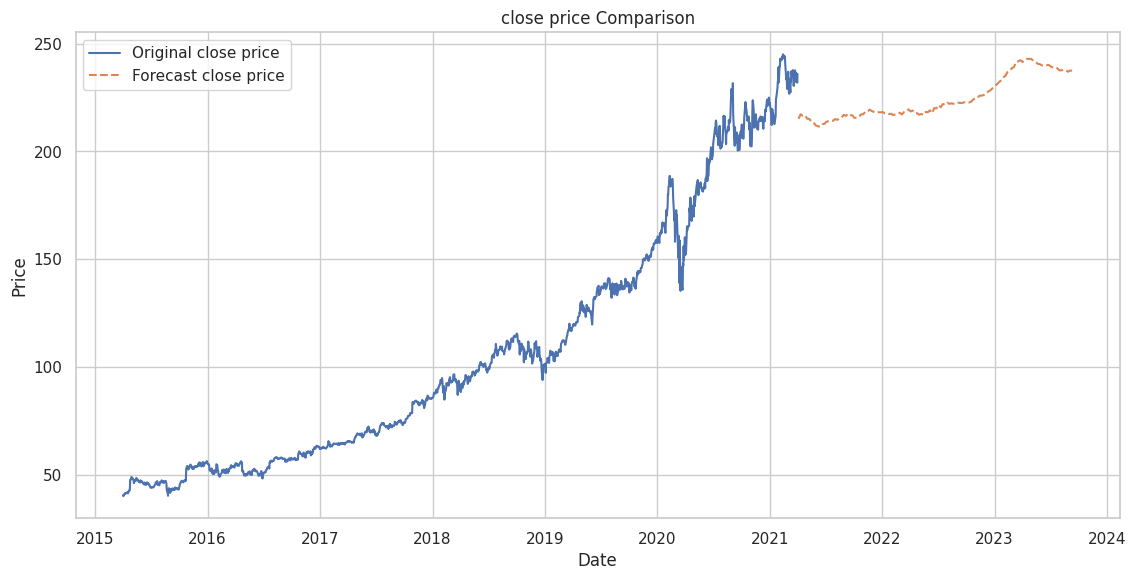

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original close price')
plt.plot(forecast_df.index, forecast_df['Close'], label='Forecast close price', linestyle='--')
plt.title('close price Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()